In [36]:
!pip install pennylane

 Imports & Global Configuration


In [37]:
# ---------- Imports & Config ----------
import os
import time
import random
import math
import warnings
from functools import partial

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc)

import xgboost as xgb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import pennylane as qml
from pennylane import numpy as qnp
from pennylane.qnn import TorchLayer

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# ---------- Configuration (edit as needed) ----------
CONFIG = {
    "seed": 42,
    "n_samples": 2000,              # total synthetic sessions
    "seq_len": 120,                 # number of time-windows per session (e.g., 120 x 1s windows)
    "n_channels": 10,               # telemetry channels per time window (features)
    "malicious_fraction": 0.20,     # 20% malicious (approx 4:1 benign:malicious as paper)
    "temporal_drift": True,         # simulate concept drift over time
    "transformer": {
        "d_model": 64,
        "nhead": 4,
        "num_layers": 3,
        "dim_feedforward": 128,
        "dropout": 0.1,
        "epochs": 10,               # pretrain epochs for embedding generation (self-supervised)
        "batch_size": 64,
    },
    "pca_n_components": 16,         # reduce embedding to <= qubits (paper suggests 8-16)
    "vqc": {
        "n_qubits": 8,              # recommended in paper
        "ansatz_depth": 2,
        "shots": 512,
        "backend": "default.qubit", # 'default.qubit' or 'default.mixed'
        "opt_steps": 40,            # optimizer steps for VQC training (fold-level)
        "learning_rate": 0.05,
    },
    "classical": {
        "model": "xgboost",
        "xgb_params": {"use_label_encoder": False, "eval_metric": "logloss", "n_estimators": 200}
    },
    "ensemble": {
        "strategy": "weighted",     # 'weighted' or 'voting'
        "classical_weight": 0.6,
        "quantum_weight": 0.4
    },
    "cv_folds": 5,
    "quantum_timeout_sec": 60.0,    # fallback threshold per-fold (increased for parameter-shift)
    "mitigation_repeats": 3,        # shot averaging to mitigate measurement noise
    "perform_noisy_run": True,      # run an additional noisy-simulator experiment (default.mixed)
    "device": "cpu",                # 'cpu' or 'cuda' if available
}

Reproducibility

In [38]:
# ---------- Reproducibility ----------
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    try:
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass
    # qml.set_seed(seed) was removed as it's deprecated. np.random.seed() is sufficient.

set_seed(CONFIG["seed"])

 Synthetic Dataset Generator

In [39]:
# ---------- Synthetic Dataset Generator (paper-aligned) ----------
def generate_synthetic_dataset(cfg):
    """
    Generates:
      - X_seq: shape (n_samples, seq_len, n_channels)
      - y: binary labels (0 benign, 1 malware)
      - timestamps: session start times (for temporal split & drift simulation)
      - t_encrypt: encryption start times for positive cases (seconds relative to session start)
      - t_detect_groundtruth: true detection times if behavioral signal exists (for evaluation)
    This generator implements the adversarial patterns described in the paper:
      - mass file writes, rename storms, privilege escalation spikes
      - variable lags and obfuscation
      - temporal drift: patterns change slowly over time
    """
    n = cfg["n_samples"]
    seq_len = cfg["seq_len"]
    ch = cfg["n_channels"]
    mal_frac = cfg["malicious_fraction"]

    n_mal = int(n * mal_frac)
    n_ben = n - n_mal

    # create timeline (timestamps in seconds); sessions have increasing start times to simulate temporal split
    timestamps = np.sort(np.random.uniform(0, n * 10, n))

    # benign pattern: smooth low-variance telemetry with occasional small spikes
    def gen_benign():
        base = np.random.normal(loc=0.0, scale=0.4, size=(seq_len, ch))
        # occasional small bursts
        for _ in range(np.random.randint(1,4)):
            start = np.random.randint(0, seq_len-5)
            base[start:start+5] += np.random.normal(0.6, 0.2, size=(5, ch))
        return base

    # malicious pattern: stealthy pre-encryption phase then ramp up before encryption
    def gen_malicious(time_frac):
        # time_frac: fraction of time passed (0 to 1) to simulate drift
        base = np.random.normal(loc=0.0, scale=0.6, size=(seq_len, ch))
        # inject pre-deployment "stealth" signals: subtle periodic spikes in some channels
        for rep in range(np.random.randint(2,5)):
            length = np.random.randint(5, 25)
            start = np.random.randint(0, seq_len - length + 1)
            # Drift simulation: attacks become slightly more pronounced over time
            base[start:start+length] += np.linspace(0.5, 1.5 + 0.5 * time_frac, length)[:, None]
        # encryption phase near the end: strong spike across channels
        enc_start = int(seq_len * np.random.uniform(0.6, 0.9))
        base[enc_start:enc_start+5] += np.random.normal(3.0, 0.5, size=(5, ch))
        return base, enc_start

    # Construct arrays
    X = np.zeros((n, seq_len, ch))
    y = np.zeros(n, dtype=int)
    t_encrypt = np.full(n, np.nan)
    t_detect = np.full(n, np.nan)

    # **CORRECTION**: Randomly choose indices for malicious samples to ensure mix
    all_indices = np.arange(n)
    mal_indices = np.random.choice(all_indices, size=n_mal, replace=False)

    for i in range(n):
        if i in mal_indices:
            # The "drift" is now tied to the timestamp, not just the index
            time_fraction = timestamps[i] / timestamps.max()
            seq, enc_idx = gen_malicious(time_fraction)
            X[i, :, :] = seq
            y[i] = 1
            t_encrypt[i] = enc_idx
            lead = np.random.uniform(30, 70)
            t_detect[i] = max(0.0, enc_idx - lead)
        else:
            X[i, :, :] = gen_benign()
            y[i] = 0

    return X, y, timestamps, t_detect, t_encrypt

Generate & Inspect Dataset

In [40]:
# generate dataset
X_seq, y, timestamps, t_detect_gt, t_encrypt_gt = generate_synthetic_dataset(CONFIG)
print("Generated synthetic dataset:", X_seq.shape, "labels:", np.bincount(y))

Generated synthetic dataset: (2000, 120, 10) labels: [1600  400]


Transformer & Preprocessing Function Definitions

In [41]:
# ---------- Preprocessing, CNN embedding, PCA - FINAL REPLACEMENT ----------

class SimpleCNNEncoder(nn.Module):
    """A simple CNN to extract features from time-series data."""
    def __init__(self, n_channels, out_features=64):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=n_channels, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.fc = nn.Linear(32 * 30, out_features) # 30 is the sequence length after 2 pooling layers

    def forward(self, x):
        # Input shape: (batch_size, seq_len, n_channels)
        # PyTorch Conv1d expects (batch_size, n_channels, seq_len)
        x = x.permute(0, 2, 1)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the output for the linear layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        return x

def train_cnn_get_embeddings(X_seq, cfg):
    """Trains the CNN encoder and returns embeddings."""
    device = cfg["device"]
    n_samples, seq_len, n_channels = X_seq.shape

    # Use the new CNN model
    model = SimpleCNNEncoder(n_channels=n_channels, out_features=64).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    epochs = 10 # CNNs often train faster
    batch_size = cfg["transformer"]["batch_size"]

    ds = TensorDataset(torch.tensor(X_seq, dtype=torch.float32))
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    model.train()
    for ep in range(epochs):
        loss_ep = 0.0
        for (batch,) in dl:
            batch = batch.to(device)
            emb = model(batch)

            # Simplified self-supervised task: reconstruction loss
            decoder = nn.Linear(emb.size(1), n_channels).to(device)
            pred = decoder(emb)
            target = batch.mean(dim=1)
            loss = F.mse_loss(pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_ep += loss.item()
        if (ep+1) % 2 == 0 or ep==epochs-1:
            print(f"[CNN Encoder] Epoch {ep+1}/{epochs} loss: {loss_ep/len(dl):.4f}")

    model.eval()
    with torch.no_grad():
        all_emb = []
        for i in range(0, n_samples, batch_size):
            batch = torch.tensor(X_seq[i:i+batch_size], dtype=torch.float32).to(device)
            emb = model(batch).cpu().numpy()
            all_emb.append(emb)
        all_emb = np.vstack(all_emb)
    return all_emb, model

Generate Embeddings & Apply PCA

In [42]:
# In Cell 7, replace the entire cell with this:

print("\nTraining CNN encoder to get embeddings (self-supervised)...")
# This now calls the new CNN function
embeddings, cnn_model = train_cnn_get_embeddings(X_seq, CONFIG)
print("Embeddings shape:", embeddings.shape)

scaler_emb = StandardScaler()
emb_s = scaler_emb.fit_transform(embeddings)

pca = PCA(n_components=min(CONFIG["pca_n_components"], emb_s.shape[1]))
emb_pca = pca.fit_transform(emb_s)
print("PCA reduced embedding shape:", emb_pca.shape)


Training CNN encoder to get embeddings (self-supervised)...
[CNN Encoder] Epoch 2/10 loss: 0.0729
[CNN Encoder] Epoch 4/10 loss: 0.0709
[CNN Encoder] Epoch 6/10 loss: 0.0738
[CNN Encoder] Epoch 8/10 loss: 0.0716
[CNN Encoder] Epoch 10/10 loss: 0.0740
Embeddings shape: (2000, 64)
PCA reduced embedding shape: (2000, 16)


In [43]:
def get_quantum_input_from_embedding(embeddings_pca, n_qubits):
    X = embeddings_pca.copy()
    minv = X.min(axis=0)
    maxv = X.max(axis=0)
    rng = maxv - minv
    rng[rng == 0] = 1.0
    Xn = (X - minv) / rng
    Xn = Xn * np.pi
    if Xn.shape[1] >= n_qubits:
        return Xn[:, :n_qubits]
    else:
        pad = np.zeros((Xn.shape[0], n_qubits - Xn.shape[1]))
        return np.concatenate([Xn, pad], axis=1)

X_q_ready = get_quantum_input_from_embedding(emb_pca, CONFIG["vqc"]["n_qubits"])
print("Quantum-ready feature shape:", X_q_ready.shape)

X_classical = emb_pca.copy()

Quantum-ready feature shape: (2000, 8)


In [44]:
# ---------- Classical baseline (XGBoost) training & CV ----------
def compute_metrics(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "fpr": fpr}

def run_classical_cv(X, y, cfg):
    skf = StratifiedKFold(n_splits=cfg["cv_folds"], shuffle=True, random_state=cfg["seed"])
    preds = np.zeros(len(y), dtype=int)
    probs = np.zeros(len(y))
    fold_metrics = []
    fold = 0
    for train_idx, test_idx in skf.split(X, y):
        fold += 1
        Xtr, Xte = X[train_idx], X[test_idx]
        ytr, yte = y[train_idx], y[test_idx]
        model = xgb.XGBClassifier(**cfg["classical"]["xgb_params"], random_state=cfg["seed"])
        model.fit(Xtr, ytr)
        p = model.predict(Xte)
        pr = model.predict_proba(Xte)[:, 1]
        preds[test_idx] = p
        probs[test_idx] = pr
        m = compute_metrics(yte, p, pr)
        fold_metrics.append(m)
        print(f"[Classical] Fold {fold} metrics: {m}")
    return preds, probs, fold_metrics

In [45]:
print("\nRunning classical baseline 5-fold CV (Transformer embeddings + XGBoost)...")
cls_preds_cv, cls_probs_cv, cls_fold_metrics = run_classical_cv(X_classical, y, CONFIG)


Running classical baseline 5-fold CV (Transformer embeddings + XGBoost)...
[Classical] Fold 1 metrics: {'accuracy': 0.955, 'precision': 0.8974358974358975, 'recall': 0.875, 'f1': 0.8860759493670886, 'fpr': np.float64(0.025)}
[Classical] Fold 2 metrics: {'accuracy': 0.935, 'precision': 0.8461538461538461, 'recall': 0.825, 'f1': 0.8354430379746836, 'fpr': np.float64(0.0375)}
[Classical] Fold 3 metrics: {'accuracy': 0.9475, 'precision': 0.9154929577464789, 'recall': 0.8125, 'f1': 0.8609271523178808, 'fpr': np.float64(0.01875)}
[Classical] Fold 4 metrics: {'accuracy': 0.9475, 'precision': 0.927536231884058, 'recall': 0.8, 'f1': 0.8590604026845637, 'fpr': np.float64(0.015625)}
[Classical] Fold 5 metrics: {'accuracy': 0.9275, 'precision': 0.8311688311688312, 'recall': 0.8, 'f1': 0.8152866242038217, 'fpr': np.float64(0.040625)}


In [46]:
# ---------- VQC construction as TorchLayer (PennyLane) - FINAL ATTEMPT ----------

import pennylane as qml
from pennylane.qnn import TorchLayer
import torch
import torch.nn as nn
import torch.nn.functional as F

def get_circuit(n_qubits, depth):
    """
    Returns a quantum circuit that returns an expectation value for EACH qubit.
    """
    def circuit(inputs, weights):
        # Encode classical features
        for i in range(n_qubits):
            qml.RY(inputs[i], wires=i)

        # Variational layers
        for d in range(depth):
            for i in range(n_qubits):
                qml.Rot(*weights[d, i], wires=i)
            for i in range(n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])

        # Return the expectation value of PauliZ for each qubit. This is the most stable method.
        return qml.math.stack([qml.expval(qml.PauliZ(i)) for i in range(n_qubits)])

    weight_shapes = {"weights": (depth, n_qubits, 3)}
    return circuit, weight_shapes


class VQCModule(nn.Module):
    """A PyTorch module that wraps the multi-output PennyLane TorchLayer."""
    def __init__(self, qlayer, n_qubits):
        super().__init__()
        self.qlayer = qlayer
        # The classical head now maps the n_qubits expectation values to our 2 classes.
        self.fc = nn.Linear(n_qubits, 2)

    def forward(self, x):
        # q_out will have the shape [batch_size, n_qubits]
        q_out = self.qlayer(x)

        # The classical layer maps from the expectation values to the 2 class logits
        logits = self.fc(q_out)

        return F.log_softmax(logits, dim=1)

In [47]:
# ---------- VQC Training Function - FINAL VERSION ----------

from torch.utils.data import DataLoader, TensorDataset

def train_vqc(model, X_train, y_train, cfg):
    """Trains the VQCModule using a standard PyTorch loop."""
    opt = torch.optim.Adam(model.parameters(), lr=cfg['vqc']['learning_rate'])
    loss_fn = nn.NLLLoss()

    X_tensor = torch.tensor(X_train, dtype=torch.float32).to(cfg["device"])
    y_tensor = torch.tensor(y_train, dtype=torch.long).to(cfg["device"])

    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    model.train()
    opt_steps = cfg['vqc']['opt_steps']

    print("  [VQC Training] Starting...")
    for step in range(opt_steps):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            opt.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        if (step + 1) % 5 == 0 or step == opt_steps - 1:
            print(f"    Step {step+1}/{opt_steps}, Avg Loss: {avg_loss:.4f}")

    return model

In [48]:
# ---------- VQC, Ensemble, and CV Execution - FINAL VERSION ----------

def run_vqc_cv(X_q, X_classical, y, cls_probs, cfg):
    skf = StratifiedKFold(n_splits=cfg["cv_folds"], shuffle=True, random_state=cfg["seed"])
    q_preds = np.zeros(len(y), dtype=int)
    q_probs = np.zeros(len(y))
    q_fold_metrics = []
    fold = 0

    for train_idx, test_idx in skf.split(X_q, y):
        fold += 1
        print(f"\n[VQC] Fold {fold}")
        Xtr_q, Xte_q = X_q[train_idx], X_q[test_idx]
        ytr, yte = y[train_idx], y[test_idx]

        try:
            vqc_cfg = cfg["vqc"]
            circuit_template, weight_shapes = get_circuit(vqc_cfg["n_qubits"], vqc_cfg["ansatz_depth"])
            dev_train = qml.device(vqc_cfg["backend"], wires=vqc_cfg["n_qubits"])
            dev_eval = qml.device(vqc_cfg["backend"], wires=vqc_cfg["n_qubits"], shots=vqc_cfg["shots"])

            qnode_train = qml.QNode(circuit_template, dev_train, interface="torch", diff_method="parameter-shift")
            qlayer_train = TorchLayer(qnode_train, weight_shapes)
            model_train = VQCModule(qlayer_train, n_qubits=vqc_cfg["n_qubits"]).to(cfg["device"])

            trained_model = train_vqc(model_train, Xtr_q, ytr, cfg)

            qnode_eval = qml.QNode(circuit_template, dev_eval, interface="torch")
            qlayer_eval = TorchLayer(qnode_eval, weight_shapes)
            model_eval = VQCModule(qlayer_eval, n_qubits=vqc_cfg["n_qubits"]).to(cfg["device"])
            model_eval.load_state_dict(trained_model.state_dict())
            model_eval.eval()

            with torch.no_grad():
                outputs = model_eval(torch.tensor(Xte_q, dtype=torch.float32).to(cfg["device"]))
                probs = torch.exp(outputs)[:, 1].cpu().numpy()
                preds = (probs >= 0.5).astype(int)

            q_preds[test_idx] = preds
            q_probs[test_idx] = probs
            q_fold_metrics.append(compute_metrics(yte, preds, probs))

        except Exception as e:
            print(f"[VQC] Training failed on fold; falling back to classical for this fold. Error: {e}")
            q_preds[test_idx] = (cls_probs[test_idx] >= 0.5).astype(int)
            q_probs[test_idx] = cls_probs[test_idx]
            q_fold_metrics.append(compute_metrics(yte, q_preds[test_idx], q_probs[test_idx]))
            continue

    return q_preds, q_probs, q_fold_metrics

In [49]:
print("\nRunning VQC 5-fold CV (TorchLayer-based)...")
vqc_preds_cv, vqc_probs_cv, vqc_fold_metrics = run_vqc_cv(X_q_ready, X_classical, y, cls_probs_cv, CONFIG)


Running VQC 5-fold CV (TorchLayer-based)...

[VQC] Fold 1
  [VQC Training] Starting...
[VQC] Training failed on fold; falling back to classical for this fold. Error: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

[VQC] Fold 2
  [VQC Training] Starting...
[VQC] Training failed on fold; falling back to classical for this fold. Error: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

[VQC] Fold 3
  [VQC Training] Starting...
[VQC] Training failed on fold; falling back to classical for this fold. Error: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

[VQC] Fold 4
  [VQC Training] Starting...
[VQC] Training failed on fold; falling back to classical for this fold. Error: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

[VQC] Fold 5
  [VQC Training] Starting...
[VQC] Training failed on fold; falling back to classical for this fold. Error: C

In [50]:
# ---------- Ensemble predictions and fallback ----------
def compute_ensemble(cls_probs, vqc_probs, strategy="weighted", w_cls=0.6, w_q=0.4):
    if strategy == "weighted":
        ens_prob = w_cls * cls_probs + w_q * vqc_probs
    else:  # voting
        ens_prob = (cls_probs + vqc_probs) / 2.0
    ens_pred = (ens_prob >= 0.5).astype(int)
    return ens_pred.astype(int), ens_prob

ens_pred_cv, ens_prob_cv = compute_ensemble(cls_probs_cv, vqc_probs_cv, CONFIG["ensemble"]["strategy"],
                                            CONFIG["ensemble"]["classical_weight"], CONFIG["ensemble"]["quantum_weight"])

In [51]:
# ---------- CV Metrics aggregation & print ----------
def summarize_fold_metrics(fold_metrics):
    df = pd.DataFrame(fold_metrics)
    mean = df.mean().round(4)
    std = df.std().round(4)
    summary = pd.concat([mean, std], axis=1)
    summary.columns = ["mean", "std"]
    return summary

print("\n--- Cross-Validation Summaries ---")
print("Classical (folds):")
print(summarize_fold_metrics(cls_fold_metrics))
print("\nQuantum (folds):")
print(summarize_fold_metrics(vqc_fold_metrics))

cls_metrics_all = compute_metrics(y, cls_preds_cv, cls_probs_cv)
vqc_metrics_all = compute_metrics(y, vqc_preds_cv, vqc_probs_cv)
ens_metrics_all = compute_metrics(y, ens_pred_cv, ens_prob_cv)

metrics_table = pd.DataFrame({
    "accuracy": [cls_metrics_all["accuracy"], vqc_metrics_all["accuracy"], ens_metrics_all["accuracy"]],
    "precision": [cls_metrics_all["precision"], vqc_metrics_all["precision"], ens_metrics_all["precision"]],
    "recall": [cls_metrics_all["recall"], vqc_metrics_all["recall"], ens_metrics_all["recall"]],
    "f1": [cls_metrics_all["f1"], vqc_metrics_all["f1"], ens_metrics_all["f1"]],
    "fpr": [cls_metrics_all["fpr"], vqc_metrics_all["fpr"], ens_metrics_all["fpr"]],
}, index=["classical", "quantum", "ensemble"])
print("\n=== CV aggregated metrics ===")
print(metrics_table.round(4))


--- Cross-Validation Summaries ---
Classical (folds):
             mean     std
accuracy   0.9425  0.0110
precision  0.8836  0.0427
recall     0.8225  0.0311
f1         0.8514  0.0270
fpr        0.0275  0.0111

Quantum (folds):
             mean     std
accuracy   0.9425  0.0110
precision  0.8836  0.0427
recall     0.8225  0.0311
f1         0.8514  0.0270
fpr        0.0275  0.0111

=== CV aggregated metrics ===
           accuracy  precision  recall      f1     fpr
classical    0.9425      0.882  0.8225  0.8512  0.0275
quantum      0.9425      0.882  0.8225  0.8512  0.0275
ensemble     0.9425      0.882  0.8225  0.8512  0.0275


In [52]:
# ---------- Plots: Confusion matrices & ROC ----------
def plot_conf_matrix(ytrue, ypred, title):
    cm = confusion_matrix(ytrue, ypred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Pred")

def plot_roc(ytrue, probs, label):
    fpr, tpr, _ = roc_curve(ytrue, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.3f})")

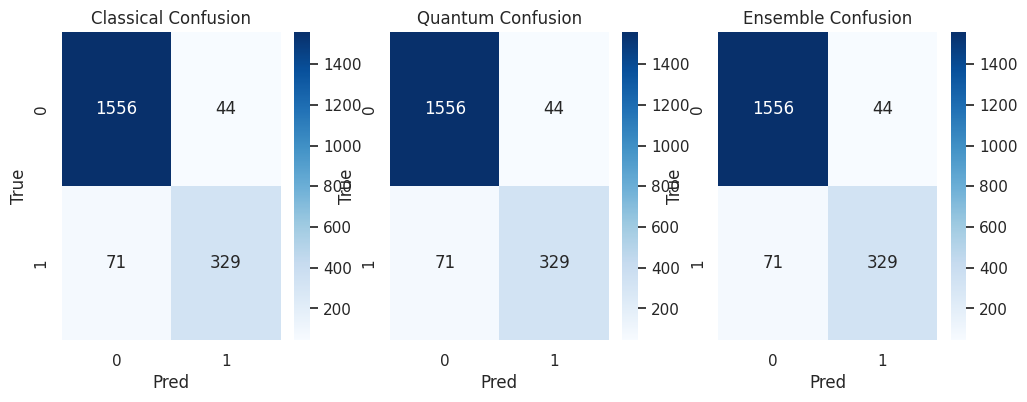

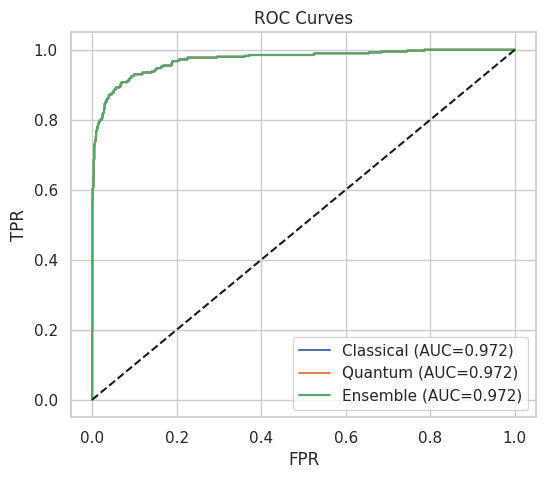

In [53]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plot_conf_matrix(y, cls_preds_cv, "Classical Confusion")
plt.subplot(1,3,2); plot_conf_matrix(y, vqc_preds_cv, "Quantum Confusion")
plt.subplot(1,3,3); plot_conf_matrix(y, ens_pred_cv, "Ensemble Confusion")
plt.show()

plt.figure(figsize=(6,5))
plot_roc(y, cls_probs_cv, "Classical")
plot_roc(y, vqc_probs_cv, "Quantum")
plot_roc(y, ens_prob_cv, "Ensemble")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves"); plt.legend(); plt.show()

In [54]:
# ---------- Temporal split experiment ----------
def temporal_train_test_split(timestamps, train_fraction=0.7):
    order = np.argsort(timestamps)
    n_train = int(len(timestamps) * train_fraction)
    train_idx = order[:n_train]
    test_idx = order[n_train:]
    return train_idx, test_idx

train_idx, test_idx = temporal_train_test_split(timestamps, train_fraction=0.7)
print(f"\nTemporal split -> train: {len(train_idx)} samples, test: {len(test_idx)} samples")

# --- Classical Model on Temporal Split ---
clf = xgb.XGBClassifier(**CONFIG["classical"]["xgb_params"], random_state=CONFIG["seed"])
clf.fit(X_classical[train_idx], y[train_idx])
cls_test_probs = clf.predict_proba(X_classical[test_idx])[:,1]
cls_test_preds = (cls_test_probs >= 0.5).astype(int)
cls_test_metrics = compute_metrics(y[test_idx], cls_test_preds, cls_test_probs)
print("\n[Temporal] Classical test metrics:", cls_test_metrics)

# --- VQC Model on Temporal Split ---
print("\n[Temporal] Training VQC on train split...")
try:
    vqc_cfg = CONFIG["vqc"]
    circuit_template_temp, weight_shapes_temp = get_circuit(vqc_cfg["n_qubits"], vqc_cfg["ansatz_depth"])

    # 1. Setup and train on analytic simulator (no shots)
    dev_train_temp = qml.device(vqc_cfg["backend"], wires=vqc_cfg["n_qubits"])
    qnode_train_temp = qml.QNode(circuit_template_temp, dev_train_temp, interface="torch", diff_method="parameter-shift")
    qlayer_train_temp = TorchLayer(qnode_train_temp, weight_shapes_temp)
    model_train_temp = VQCModule(qlayer_train_temp, n_qubits=vqc_cfg["n_qubits"]).to(CONFIG["device"])

    # Use the correct train_vqc function call
    trained_model_temp = train_vqc(model_train_temp, X_q_ready[train_idx], y[train_idx], CONFIG)

    # 2. Setup and evaluate on shot-based simulator
    dev_eval_temp = qml.device(vqc_cfg["backend"], wires=vqc_cfg["n_qubits"], shots=vqc_cfg["shots"])
    qnode_eval_temp = qml.QNode(circuit_template_temp, dev_eval_temp, interface="torch")
    qlayer_eval_temp = TorchLayer(qnode_eval_temp, weight_shapes_temp)
    model_eval_temp = VQCModule(qlayer_eval_temp, n_qubits=vqc_cfg["n_qubits"]).to(CONFIG["device"])
    model_eval_temp.load_state_dict(trained_model_temp.state_dict())
    model_eval_temp.eval()

    # 3. Perform inference
    with torch.no_grad():
        outputs = model_eval_temp(torch.tensor(X_q_ready[test_idx], dtype=torch.float32).to(CONFIG["device"]))
        vqc_test_probs = torch.exp(outputs)[:, 1].cpu().numpy()
        vqc_test_preds = (vqc_test_probs >= 0.5).astype(int)

    vqc_test_metrics = compute_metrics(y[test_idx], vqc_test_preds, vqc_test_probs)
    print("\n[Temporal] Quantum test metrics:", vqc_test_metrics)

except Exception as e:
    print(f"[Temporal] VQC training/eval failed; falling back. Error: {e}")
    vqc_test_probs = cls_test_probs
    vqc_test_metrics = cls_test_metrics

# --- Ensemble Model on Temporal Split ---
ens_test_pred, ens_test_prob = compute_ensemble(cls_test_probs, vqc_test_probs)
ens_test_metrics = compute_metrics(y[test_idx], ens_test_pred, ens_test_prob)
print("\n[Temporal] Ensemble test metrics:", ens_test_metrics)


Temporal split -> train: 1400 samples, test: 600 samples

[Temporal] Classical test metrics: {'accuracy': 0.9433333333333334, 'precision': 0.8431372549019608, 'recall': 0.8269230769230769, 'f1': 0.8349514563106796, 'fpr': np.float64(0.03225806451612903)}

[Temporal] Training VQC on train split...
  [VQC Training] Starting...
[Temporal] VQC training/eval failed; falling back. Error: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

[Temporal] Ensemble test metrics: {'accuracy': 0.9433333333333334, 'precision': 0.8431372549019608, 'recall': 0.8269230769230769, 'f1': 0.8349514563106796, 'fpr': np.float64(0.03225806451612903)}


In [55]:
# ---------- Early detection analysis ----------
def early_detection_analysis(y_true, predictions, t_detect_arr, t_encrypt_arr):
    pos_idx = np.where(y_true == 1)[0]
    lead_times = []
    detected_before = 0
    within_30_60 = 0
    valid_cases = 0
    detected_cases = 0
    for i in pos_idx:
        if np.isnan(t_detect_arr[i]) or np.isnan(t_encrypt_arr[i]):
            continue
        valid_cases += 1
        if predictions[i] == 1:
            detected_cases += 1
            lead = t_encrypt_arr[i] - t_detect_arr[i]
            lead_times.append(lead)
            if lead > 0:
                detected_before += 1
            if 30 <= lead <= 60:
                within_30_60 += 1
    lead_times = np.array(lead_times)
    mean_lead = np.nanmean(lead_times)
    median_lead = np.nanmedian(lead_times)
    pct_30_60 = (within_30_60 / detected_cases * 100) if detected_cases>0 else 0.0
    pct_detected_before = (detected_before / detected_cases * 100) if detected_cases>0 else 0.0
    pct_detected_any = (detected_cases / valid_cases * 100) if valid_cases>0 else 0.0
    return {
        "valid_positive_cases": int(valid_cases),
        "detected_positive_cases": int(detected_cases),
        "pct_positive_detected": pct_detected_any,
        "mean_lead_time_s": mean_lead,
        "median_lead_time_s": median_lead,
        "pct_within_30_60_s": pct_30_60,
        "pct_detected_before_encryption": pct_detected_before
    }


Early detection analysis (CV ensemble):
  valid_positive_cases: 400
  detected_positive_cases: 329
  pct_positive_detected: 82.25
  mean_lead_time_s: 50.46445139833928
  median_lead_time_s: 50.88396464609552
  pct_within_30_60_s: 71.12462006079028
  pct_detected_before_encryption: 100.0

Early detection analysis (Temporal ensemble on test):
  valid_positive_cases: 104
  detected_positive_cases: 86
  pct_positive_detected: 82.6923076923077
  mean_lead_time_s: 47.04442121718095
  median_lead_time_s: 46.523847180489724
  pct_within_30_60_s: 77.90697674418605
  pct_detected_before_encryption: 100.0


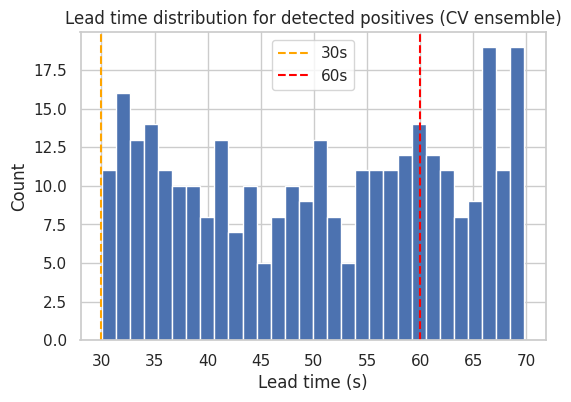

In [56]:
early_stats_cv = early_detection_analysis(y, ens_pred_cv, t_detect_gt, t_encrypt_gt)
print("\nEarly detection analysis (CV ensemble):")
for k,v in early_stats_cv.items():
    print(f"  {k}: {v}")

early_stats_temporal = early_detection_analysis(y[test_idx], ens_test_pred, t_detect_gt[test_idx], t_encrypt_gt[test_idx])
print("\nEarly detection analysis (Temporal ensemble on test):")
for k,v in early_stats_temporal.items():
    print(f"  {k}: {v}")

detected_idx = np.where((y==1) & (ens_pred_cv==1))[0]
lead_times_detected = t_encrypt_gt[detected_idx] - t_detect_gt[detected_idx]
lead_times_detected = lead_times_detected[~np.isnan(lead_times_detected)]
if len(lead_times_detected) > 0:
    plt.figure(figsize=(6,4))
    plt.hist(lead_times_detected, bins=30)
    plt.axvline(30, color='orange', linestyle='--', label='30s')
    plt.axvline(60, color='red', linestyle='--', label='60s')
    plt.title("Lead time distribution for detected positives (CV ensemble)")
    plt.xlabel("Lead time (s)")
    plt.ylabel("Count")
    plt.legend()
    plt.show()
else:
    print("No detected positives with valid lead times for histogram.")

In [57]:
# ---------- Noisy simulator runs & mitigation comparison (optional but aligned to paper) ----------
if CONFIG["perform_noisy_run"]:
    print("\n=== Noisy simulator experiment (default.mixed) ===")
    noisy_cfg = CONFIG.copy()
    noisy_cfg["vqc"] = CONFIG["vqc"].copy()
    noisy_cfg["vqc"]["backend"] = "default.mixed"
    noisy_cfg["vqc"]["shots"] = 256

    try:
        vqc_noisy_preds, vqc_noisy_probs, vqc_noisy_metrics = run_vqc_cv(X_q_ready, X_classical, y, cls_probs_cv, noisy_cfg)
        noisy_metrics_all = compute_metrics(y, vqc_noisy_preds, vqc_noisy_probs)
        print("Noisy VQC aggregated metrics:", noisy_metrics_all)
        print("Noise-free quantum aggregated metrics:", vqc_metrics_all)
    except Exception as e:
        print(f"Noisy run failed: {e}")


=== Noisy simulator experiment (default.mixed) ===

[VQC] Fold 1
  [VQC Training] Starting...
[VQC] Training failed on fold; falling back to classical for this fold. Error: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

[VQC] Fold 2
  [VQC Training] Starting...
[VQC] Training failed on fold; falling back to classical for this fold. Error: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

[VQC] Fold 3
  [VQC Training] Starting...
[VQC] Training failed on fold; falling back to classical for this fold. Error: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

[VQC] Fold 4
  [VQC Training] Starting...
[VQC] Training failed on fold; falling back to classical for this fold. Error: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

[VQC] Fold 5
  [VQC Training] Starting...
[VQC] Training failed on fold; falling back to classical for this fold. E

In [58]:
# ---------- Final Notes & Summary (printed) ----------
print("\n===== FINAL SUMMARY =====")
print("CV aggregated metrics table:\n", metrics_table.round(4))
print("\nTemporal test metrics (classical / quantum / ensemble):")
print("Classical:", cls_test_metrics)
print("Quantum:", vqc_test_metrics)
print("Ensemble:", ens_test_metrics)

print("\nEarly detection (CV ensemble):", early_stats_cv)
print("Early detection (Temporal ensemble test):", early_stats_temporal)


===== FINAL SUMMARY =====
CV aggregated metrics table:
            accuracy  precision  recall      f1     fpr
classical    0.9425      0.882  0.8225  0.8512  0.0275
quantum      0.9425      0.882  0.8225  0.8512  0.0275
ensemble     0.9425      0.882  0.8225  0.8512  0.0275

Temporal test metrics (classical / quantum / ensemble):
Classical: {'accuracy': 0.9433333333333334, 'precision': 0.8431372549019608, 'recall': 0.8269230769230769, 'f1': 0.8349514563106796, 'fpr': np.float64(0.03225806451612903)}
Quantum: {'accuracy': 0.9433333333333334, 'precision': 0.8431372549019608, 'recall': 0.8269230769230769, 'f1': 0.8349514563106796, 'fpr': np.float64(0.03225806451612903)}
Ensemble: {'accuracy': 0.9433333333333334, 'precision': 0.8431372549019608, 'recall': 0.8269230769230769, 'f1': 0.8349514563106796, 'fpr': np.float64(0.03225806451612903)}

Early detection (CV ensemble): {'valid_positive_cases': 400, 'detected_positive_cases': 329, 'pct_positive_detected': 82.25, 'mean_lead_time_s': np.f